### 模块和参数

In [1]:
from datacleanv2 import *
from SetRNN import *
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence
from collections import Counter # 用于统计计数的工具
import time # 用于计时
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils # 用于处理变长序列，如填充和打包
from torch.utils.data import Dataset, DataLoader # PyTorch 数据加载工具
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm # 进度条库，使用 tqdm.tqdm
import random
import pyreadstat
import copy # 用于复制模型参数或列表
import matplotlib.pyplot as plt # 用于绘图
import seaborn as sns # 用于更美观的统计图，特别是热力图
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EARLY_ITER_BATCH_THRESHOLD = 3 # 在前 3 轮迭代中使用部分批次 (适应总迭代 10)
EARLY_ITER_BATCH_PERCENT = 0.3

# 超参数和常量定义
NUM_MAIN_MODELS = 3 # 主要的聚类模型数量
NUM_COMBINED_SETTINGS = 125 # combined_setting 的总类别数 (0-124)
EMBEDDING_DIM = 16 # combined_setting 的嵌入向量维度，可调整
HIDDEN_SIZE = 64   # RNN 隐藏层大小，可调整
NUM_RNN_LAYERS = 2 # RNN 层数
# 注意: TIME_LOSS_SCALER 可能需要根据实际 delta_t 的规模重新调整
TIME_LOSS_SCALER = 1 # time delta_t MSE 损失的缩放因子，需要根据实际损失值大小调整
TOTAL_EM_ITERATIONS = 10 # EM 迭代总次数 (根据要求修改为 10)
CONVERGENCE_THRESHOLD = 0.05 # 收敛阈值，分配改变的序列比例低于此值时停止 (5%)

# 干扰项处理参数
NUM_RAND_SEQUENCES = 250 # 干扰项的已知数量
INTERFERENCE_CLUSTER_LABEL = 3 # 将干扰项分配到的簇的索引 (0, 1, 2 是主簇，3 是干扰簇)
INTERFERENCE_DETECTION_START_ITER = 2 # 从第 5 轮迭代 (索引 4) 的 E 步开始检测干扰项
# 检测干扰项的高损失阈值：需要根据训练中观察到的损失值范围来调整
# 如果一个序列在所有模型上的平均损失超过这个阈值，则可能被认为是干扰项。
# ！！！重要参数，需要根据实际运行观察的损失值调整！！！
# 在模拟数据上运行一次，观察损失值的分布，尤其是 rand_label 序列的损失。
HIGH_AVG_LOSS_THRESHOLD = 0.5 ## <--- !!! 初始值，请务必根据实际情况调整 !!!

# M 步训练参数 (每个 EM 迭代中的训练 epochs)
# epochs 计划表：根据迭代次数使用不同数量的 epochs
EPOCH_SCHEDULE = [1] * 5 + [2]* 5 # 示例：前 3 轮迭代训练 2 epoch，接下来 7 轮训练 5 epoch (适应总迭代 10)
BATCH_SIZE = 32 # M 步训练时的批次大小
# 在早期迭代中是否只使用部分批次来加速训练
EARLY_ITER_BATCH_THRESHOLD = 3 # 在前 3 轮迭代中使用部分批次 (适应总迭代 10)
EARLY_ITER_BATCH_PERCENT = 0.3 # 在启用部分批次训练时使用的批次比例 (30%)

### 代码

##### 是否要将setting_seq的首项修改一下

In [2]:
#读取数据
df,mata = pyreadstat.read_sav(r"E:\复旦大学\研一上\科研\评分剪枝算法\数据\data\CBA_cp025q01_logs12_SPSS.sav")
final_result_list_raw=create_time_series_with_result(remove_consecutive_duplicates(transform_sub_dfs(split_strict_paired_events(df))))
#final_result_list = random.sample(final_result_list_raw, 10000)
transformed_list_mix = transform_setting_data_handle_categorical_input(final_result_list_raw)
transformed_list=[item for item in transformed_list_mix if len(item[0])>=3]#去除过短的序列

# 读取洗乱后的数据
seeds = 1000
transformed_list_name="ListShuffle_{}.pkl".format(seeds)
# 读取数据
with open(transformed_list_name, 'rb') as f:  # 'rb' 表示二进制读取模式
    loaded_list = pickle.load(f)  # 从文件读取并反序列化

# 读取分类结果
final_assignment_list= np.load("final_assignments.npy")

# 读取模型参数
models = [SettingPredictorRNN(embedding_dim=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_rnn_layers=NUM_RNN_LAYERS, num_categories=NUM_COMBINED_SETTINGS).to(device) for _ in range(NUM_MAIN_MODELS)]
models[0] = torch.load("model1.pth",weights_only=False)
models[1] = torch.load("model2.pth",weights_only=False)   
models[2] = torch.load("model3.pth",weights_only=False)
Model = torch.load("TotalModel.pth",weights_only=False)

## 特化模型删高阈值

### 使用特化模型对每一步进行评估

In [3]:
#计算每个序列的损失
setting_loss_list=[None]*len(loaded_list)
time_loss_list=[None]*len(loaded_list)
for i in range(len(loaded_list)):
    seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
    seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
    time_criterion = nn.MSELoss(reduction= "sum")
    setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
    if final_assignment_list[i] >= len(models):
        setting_loss_list[i] = [0]
        time_loss_list[i] = [0]
        continue
    model = models[final_assignment_list[i]]

    #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
    #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
    deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
    setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

    deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
    setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

    input_len = seq_time.shape[0] - 2#输出输出的长度
    length = torch.tensor([input_len])

    #模型预测
    predict_deltaT, predict_setting,_ = model(deltaT_inputs, setting_inputs, length)
    
    #计算损失
    seq_time_loss_tensor=[time_criterion(predict_deltaT.squeeze(0)[i], deltaT_targets.squeeze(0)[i]) for i in range(predict_deltaT.squeeze(0).shape[0])]
    seq_setting_loss_tensor=[setting_criterion(predict_setting.squeeze(0)[i].unsqueeze(0), setting_targets.squeeze(0)[i].unsqueeze(0)) for i in range(predict_setting.squeeze(0).shape[0])]
    
    seq_setting_loss_list=[_.item() for _ in seq_time_loss_tensor]
    seq_time_loss_list=[_.item() for _ in seq_setting_loss_tensor]
    setting_loss_list[i]=seq_setting_loss_list
    time_loss_list[i]=seq_time_loss_list

#total_loss_list代表每个列表每一步的总损失
total_loss_list = [[setting_loss_list[i][j]+ time_loss_list[i][j] for j in range(len(setting_loss_list[i]))]for i in range(len(setting_loss_list)) ]
    
    

In [4]:
#将损失列表展平
#setting_loss_distribution 和 time_loss_distribution分别为设置和时间的损失值展平
setting_loss_distribution=[item for list_item in setting_loss_list for item in list_item]
time_loss_distribution=[item for list_item in time_loss_list for item in list_item]
#Total_step_length为所有步骤的总数
total_step_length=len(setting_loss_distribution)
#将两种损失相加，得到每个步骤的总损失total_loss_distribution
total_loss_distribution=[setting_loss_distribution[i] + time_loss_distribution[i] for i in range(len(setting_loss_distribution))]

In [5]:
threshold=95
setting_threshold = np.percentile(setting_loss_distribution, threshold)
time_threshold = np.percentile(time_loss_distribution, threshold)
print("Setting Loss",threshold,"th Percentile:", setting_threshold,"\nTime Loss ",threshold,"th Percentile:", time_threshold)
total_threshold = np.percentile(total_loss_distribution, threshold)
print("total Loss",threshold,"th Percentile:", total_threshold)

Setting Loss 95 th Percentile: 85.03319625854489 
Time Loss  95 th Percentile: 5.453453540802002
total Loss 95 th Percentile: 87.47797641754147


In [6]:
outliers = [(i, j) for i, chain in enumerate(total_loss_list) for j, loss in enumerate(chain) if loss > total_threshold]
print("共从",total_step_length,"个步骤中检测到",len(outliers),"个异常值")

共从 411695 个步骤中检测到 20585 个异常值


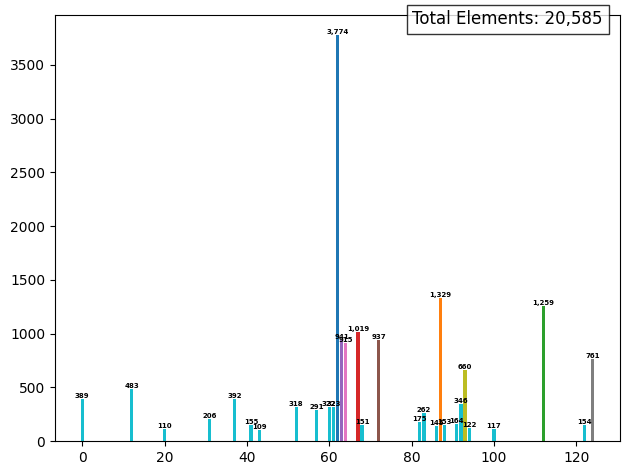

In [7]:
#先绘制被标记的setting分布
Pruned_Setting=[loaded_list[i][0]["combined_setting"].values[j+1] for i, j in outliers] # 仅保留异常值对应的序列
result = Counter(Pruned_Setting).most_common(30)
elements, counts = zip(*result)

# 绘制条形图
colors = plt.cm.tab10(np.arange(len(elements)))
bars = plt.bar(elements, counts, color=colors)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',  # 格式化数字添加千位分隔符
             ha='center', va='bottom',
             fontsize=5, fontweight='bold')
    
    # 添加总数信息
total = len(Pruned_Setting)
plt.figtext(0.95, 0.95, f'Total Elements: {total:,}', 
            ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

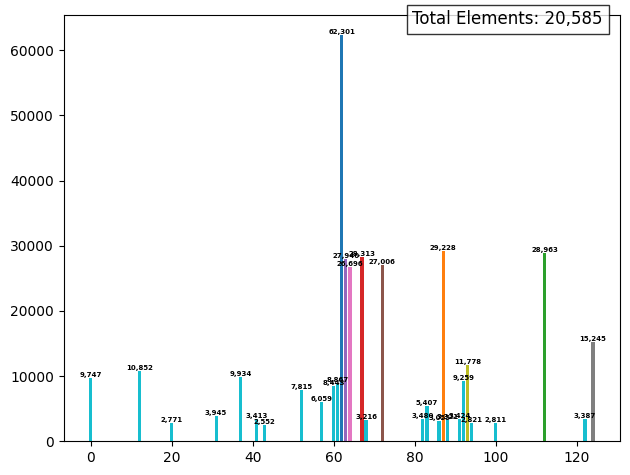

In [8]:
#绘制全体setting分布
All_Setting=[loaded_list[i][0]["combined_setting"].values[j] for i in range(len(loaded_list)) for j in range(len(loaded_list[i][0]["combined_setting"].values))]
result = Counter(All_Setting).most_common(30)
all_elements, counts = zip(*result)

# 绘制条形图
colors = plt.cm.tab10(np.arange(len(elements)))
bars = plt.bar(elements, counts, color=colors)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',  # 格式化数字添加千位分隔符
             ha='center', va='bottom',
             fontsize=5, fontweight='bold')
    
# 添加总数信息
total = len(Pruned_Setting)
plt.figtext(0.95, 0.95, f'Total Elements: {total:,}', 
            ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

### 依据特化模型的标记重新分类

In [9]:
pruned_setting_loss_list=[None]*len(loaded_list)
pruned_time_loss_list=[None]*len(loaded_list)
changed_seq=[]
for i in range(len(loaded_list)):#第i个序列
    seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
    seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
    time_criterion = nn.MSELoss(reduction= "sum")
    setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
    if final_assignment_list[i] >= len(models):
        setting_loss_list[i] = [0]
        time_loss_list[i] = [0]
        continue

    #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
    #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
    deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
    setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

    deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
    setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

    input_len = seq_time.shape[0] - 2#输出输出的长度
    length = torch.tensor([input_len])
    
    #复制原始输入和目标张量，以便在删除异常点后进行修剪,将张量转换为列表（保留二维结构）,存入“pruned_...类型_输入/输出_list”中
    pruned_deltaT_inputs_list, pruned_setting_inputs_list, pruned_deltaT_targets_list, pruned_setting_targets_list= deltaT_inputs.clone().tolist(), setting_inputs.clone().tolist(), deltaT_targets.clone().tolist(), setting_targets.clone().tolist()
    indices_to_remove = [y for _, y in outliers if _ ==i]# 从outlier中提取所有序列标号为i的异常点（即第一个元素为i的数组),忽略x，只取y
    indices_to_remove = sorted(list(set(indices_to_remove)),reverse=True)  # 去重,降序排序(先删后面的，避免改变索引位置),indices_to_remove是储存第i个序列中需要删除的索引列表,注意sorted和.sort的区别
    #***测试用待删print(i,indices_to_remove)

    # 如果没有可删除的，则跳过
    if not indices_to_remove:
        continue
    # 如果所有步骤都是异常点，则跳过
    if len(pruned_deltaT_inputs_list[0]) == len(indices_to_remove):
        print("序列",i,"的所有步骤均为异常点，跳过")
        continue
    for index in indices_to_remove:
        # 检查索引index是否在有效范围内
        if 0 <= index < len(pruned_deltaT_inputs_list[0]):# 删除被标记的步骤 <bug:只删去了t_input的异常点,忘记了其他的>
            del pruned_deltaT_inputs_list[0][index]
            del pruned_setting_inputs_list[0][index]
            del pruned_deltaT_targets_list[0][index]
            del pruned_setting_targets_list[0][index]
        else:
            # 可选：处理索引越界情况（例如打印警告或忽略）
            print(f"警告: 索引 {index} 超出范围，忽略删除")
            # 或者直接忽略

    pruned_deltaT_inputs, pruned_setting_inputs, pruned_deltaT_targets, pruned_setting_targets = torch.tensor(pruned_deltaT_inputs_list).to(device),torch.tensor(pruned_setting_inputs_list).to(device), torch.tensor(pruned_deltaT_targets_list).to(device), torch.tensor(pruned_setting_targets_list).to(device)
    # 现在，pruned_()_() 就是删除异常点后的数据链,<bug:忘记使用to(device)>
    pruned_length = torch.tensor([pruned_deltaT_inputs.shape[1]])#pruned_length为删除后的长度，从数据中取，并转化为张量

    #***检验用待删print(pruned_deltaT_inputs_list.shape,pruned_length, pruned_setting_inputs.shape[1])

    #使用所有模型分别计算损失
    model_loss = [0] * len(models) # 初始化每个模型的损失列表
    for j in range(len(models)):
        model = models[j]

        #模型预测
        pruned_predict_deltaT, pruned_predict_setting,_ = model(pruned_deltaT_inputs, pruned_setting_inputs, pruned_length)

        #计算损失,seq代表按每一步计损失并编入列表
        pruned_seq_time_loss_tensor=[time_criterion(pruned_predict_deltaT.squeeze(0)[i], pruned_deltaT_targets.squeeze(0)[i]) for i in range(pruned_predict_deltaT.squeeze(0).shape[0])]
        pruned_seq_setting_loss_tensor=[setting_criterion(pruned_predict_setting.squeeze(0)[i].unsqueeze(0), pruned_setting_targets.squeeze(0)[i].unsqueeze(0)) for i in range(pruned_predict_setting.squeeze(0).shape[0])]
        pruned_seq_setting_loss_list=[_.item() for _ in pruned_seq_time_loss_tensor]
        pruned_seq_time_loss_list=[_.item() for _ in pruned_seq_setting_loss_tensor]

        model_loss[j] = sum(pruned_seq_setting_loss_list)+ sum(pruned_seq_time_loss_list) # 计算剪后序列i在模型j上的总损失
        #***测试用待删print(model_loss[j])

    min_modelloss = min(model_loss)
    min_modelindex = model_loss.index(min_modelloss)#找出剪后的最佳模型
    if min_modelindex != final_assignment_list[i] and final_assignment_list[i] < len(models):#若与原分配不同，则打印并记录
        print("序列",i,"的最佳模型由",final_assignment_list[i],"变为",min_modelindex)
        changed_seq.append(i)
    #else:
    #    ***测试用待删print("模型损失:",model_loss,"序号不变",final_assignment_list[i])#<bug:在print()立马加入print(model_loss)会输出None>


序列 5 的最佳模型由 0 变为 1
序列 18 的所有步骤均为异常点，跳过
序列 25 的最佳模型由 0 变为 2
序列 29 的最佳模型由 1 变为 2
序列 30 的最佳模型由 0 变为 2
序列 36 的最佳模型由 1 变为 2
序列 50 的所有步骤均为异常点，跳过
序列 60 的最佳模型由 1 变为 2
序列 65 的最佳模型由 1 变为 2
序列 68 的最佳模型由 0 变为 2
序列 82 的最佳模型由 0 变为 2
序列 85 的最佳模型由 0 变为 1
序列 86 的最佳模型由 1 变为 2
序列 92 的最佳模型由 1 变为 2
序列 93 的最佳模型由 0 变为 2
序列 94 的最佳模型由 0 变为 2
序列 122 的最佳模型由 0 变为 2
序列 130 的最佳模型由 0 变为 2
序列 136 的最佳模型由 1 变为 2
序列 138 的最佳模型由 1 变为 2
序列 144 的最佳模型由 0 变为 1
序列 155 的最佳模型由 1 变为 2
序列 159 的最佳模型由 0 变为 1
序列 162 的最佳模型由 1 变为 2
序列 182 的最佳模型由 0 变为 1
序列 186 的最佳模型由 1 变为 2
序列 197 的最佳模型由 1 变为 2
序列 199 的最佳模型由 0 变为 2
序列 207 的最佳模型由 0 变为 2
序列 208 的最佳模型由 1 变为 2
序列 211 的最佳模型由 0 变为 2
序列 215 的最佳模型由 1 变为 2
序列 226 的最佳模型由 0 变为 2
序列 227 的最佳模型由 1 变为 2
序列 229 的最佳模型由 0 变为 1
序列 242 的最佳模型由 1 变为 2
序列 270 的最佳模型由 0 变为 2
序列 271 的最佳模型由 0 变为 1
序列 278 的最佳模型由 1 变为 2
序列 289 的最佳模型由 1 变为 2
序列 313 的最佳模型由 1 变为 2
序列 337 的最佳模型由 0 变为 1
序列 346 的最佳模型由 1 变为 2
序列 347 的最佳模型由 1 变为 2
序列 350 的最佳模型由 1 变为 2
序列 351 的最佳模型由 1 变为 2
序列 353 的最佳模型由 0 变为 1
序列 373 的最佳模型由 1 变为 2
序列 382 的最

In [10]:
print("总序列数",len(loaded_list))
print("标记数（被重新分类的）",len(set([i[0] for i in outliers])))
print("被改变序列数",len(changed_seq))
print()

总序列数 26287
标记数（被重新分类的） 11513
被改变序列数 3210



## 使用整体模型删高阈值

### 使用整体模型对每一步进行评估

In [11]:
#计算每个序列的损失
setting_loss_list=[None]*len(loaded_list)
time_loss_list=[None]*len(loaded_list)
for i in range(len(loaded_list)):
    seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
    seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
    time_criterion = nn.MSELoss(reduction= "sum")
    setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
    if final_assignment_list[i] >= len(models):
        setting_loss_list[i] = [0]
        time_loss_list[i] = [0]
        continue
    model = Model

    #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
    #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
    deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
    setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

    deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
    setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

    input_len = seq_time.shape[0] - 2#输出输出的长度
    length = torch.tensor([input_len])

    #模型预测
    predict_deltaT, predict_setting,_ = model(deltaT_inputs, setting_inputs, length)
    
    #计算损失
    seq_time_loss_tensor=[time_criterion(predict_deltaT.squeeze(0)[i], deltaT_targets.squeeze(0)[i]) for i in range(predict_deltaT.squeeze(0).shape[0])]
    seq_setting_loss_tensor=[setting_criterion(predict_setting.squeeze(0)[i].unsqueeze(0), setting_targets.squeeze(0)[i].unsqueeze(0)) for i in range(predict_setting.squeeze(0).shape[0])]
    
    seq_setting_loss_list=[_.item() for _ in seq_time_loss_tensor]
    seq_time_loss_list=[_.item() for _ in seq_setting_loss_tensor]
    setting_loss_list[i]=seq_setting_loss_list
    time_loss_list[i]=seq_time_loss_list

#total_loss_list代表每个列表每一步的总损失
total_loss_list = [[setting_loss_list[i][j]+ time_loss_list[i][j] for j in range(len(setting_loss_list[i]))]for i in range(len(setting_loss_list)) ]
    
    

In [12]:
#将损失列表展平
#setting_loss_distribution 和 time_loss_distribution分别为设置和时间的损失值展平
setting_loss_distribution=[item for list_item in setting_loss_list for item in list_item]
time_loss_distribution=[item for list_item in time_loss_list for item in list_item]
#Total_step_length为所有步骤的总数
total_step_length=len(setting_loss_distribution)
#将两种损失相加，得到每个步骤的总损失total_loss_distribution
total_loss_distribution=[setting_loss_distribution[i] + time_loss_distribution[i] for i in range(len(setting_loss_distribution))]

In [13]:
threshold=95
setting_threshold = np.percentile(setting_loss_distribution, threshold)
time_threshold = np.percentile(time_loss_distribution, threshold)
print("Setting Loss",threshold,"th Percentile:", setting_threshold,"\nTime Loss ",threshold,"th Percentile:", time_threshold)
total_threshold = np.percentile(total_loss_distribution, threshold)
print("total Loss",threshold,"th Percentile:", total_threshold)

Setting Loss 95 th Percentile: 96.93874206542966 
Time Loss  95 th Percentile: 6.725960969924927
total Loss 95 th Percentile: 100.67390465736389


In [14]:
outliers = [(i, j) for i, chain in enumerate(total_loss_list) for j, loss in enumerate(chain) if loss > total_threshold]
print("共从",total_step_length,"个步骤中检测到",len(outliers),"个异常值")

共从 411695 个步骤中检测到 20585 个异常值


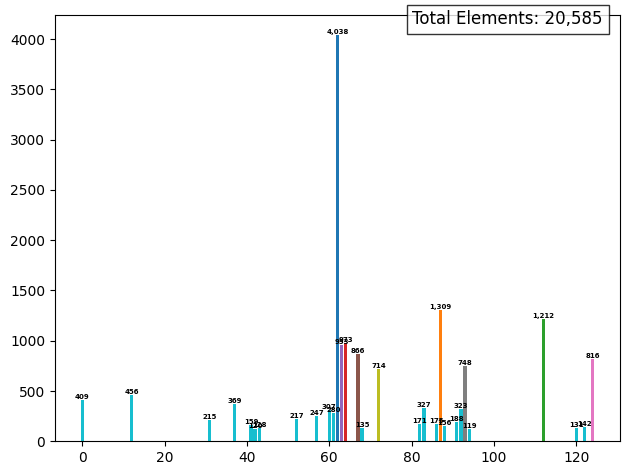

In [15]:
#先绘制被标记setting分布
Pruned_Setting=[loaded_list[i][0]["combined_setting"].values[j+1] for i, j in outliers] # 仅保留异常值对应的序列
result = Counter(Pruned_Setting).most_common(30)
elements, counts = zip(*result)

# 绘制条形图
colors = plt.cm.tab10(np.arange(len(elements)))
bars = plt.bar(elements, counts, color=colors)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',  # 格式化数字添加千位分隔符
             ha='center', va='bottom',
             fontsize=5, fontweight='bold')
    
    # 添加总数信息
total = len(Pruned_Setting)
plt.figtext(0.95, 0.95, f'Total Elements: {total:,}', 
            ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

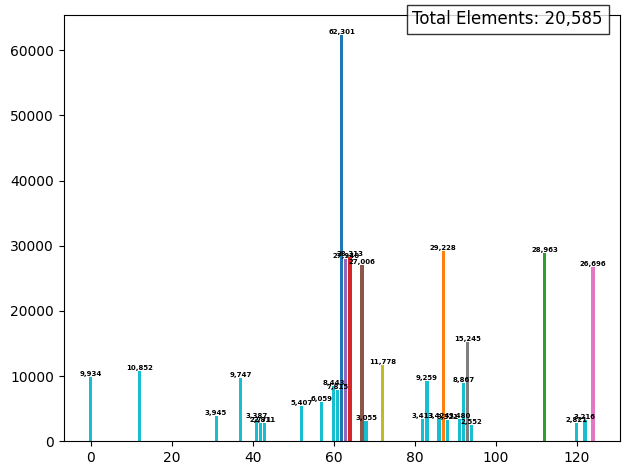

In [16]:
#绘制全体setting分布
All_Setting=[loaded_list[i][0]["combined_setting"].values[j] for i in range(len(loaded_list)) for j in range(len(loaded_list[i][0]["combined_setting"].values))]
result = Counter(All_Setting).most_common(30)
all_elements, counts = zip(*result)

# 绘制条形图
colors = plt.cm.tab10(np.arange(len(elements)))
bars = plt.bar(elements, counts, color=colors)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',  # 格式化数字添加千位分隔符
             ha='center', va='bottom',
             fontsize=5, fontweight='bold')
    
# 添加总数信息
total = len(Pruned_Setting)
plt.figtext(0.95, 0.95, f'Total Elements: {total:,}', 
            ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

### 依据整体模型的标记重新分类

In [17]:
pruned_setting_loss_list=[None]*len(loaded_list)
pruned_time_loss_list=[None]*len(loaded_list)
changed_seq=[]
for i in range(len(loaded_list)):#第i个序列
    seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
    seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
    time_criterion = nn.MSELoss(reduction= "sum")
    setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
    if final_assignment_list[i] >= len(models):
        setting_loss_list[i] = [0]
        time_loss_list[i] = [0]
        continue

    #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
    #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
    deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
    setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

    deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
    setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

    input_len = seq_time.shape[0] - 2#输出输出的长度
    length = torch.tensor([input_len])
    
    #复制原始输入和目标张量，以便在删除异常点后进行修剪,将张量转换为列表（保留二维结构）,存入“pruned_...类型_输入/输出_list”中
    pruned_deltaT_inputs_list, pruned_setting_inputs_list, pruned_deltaT_targets_list, pruned_setting_targets_list= deltaT_inputs.clone().tolist(), setting_inputs.clone().tolist(), deltaT_targets.clone().tolist(), setting_targets.clone().tolist()
    indices_to_remove = [y for _, y in outliers if _ ==i]# 从outlier中提取所有序列标号为i的异常点（即第一个元素为i的数组),忽略x，只取y
    indices_to_remove = sorted(list(set(indices_to_remove)),reverse=True)  # 去重,降序排序(先删后面的，避免改变索引位置),indices_to_remove是储存第i个序列中需要删除的索引列表,注意sorted和.sort的区别
    #***测试用待删print(i,indices_to_remove)

    # 如果没有可删除的，则跳过
    if not indices_to_remove:
        continue
    # 如果所有步骤都是异常点，则跳过
    # ***是否要记录所有步骤都异常的序列的总数**？
    if len(pruned_deltaT_inputs_list[0]) == len(indices_to_remove):
        print("序列",i,"的所有步骤均为异常点，跳过")
        continue
    for index in indices_to_remove:
        # 检查索引index是否在有效范围内
        if 0 <= index < len(pruned_deltaT_inputs_list[0]):# 删除被标记的步骤 <bug:只删去了t_input的异常点,忘记了其他的>
            del pruned_deltaT_inputs_list[0][index]
            del pruned_setting_inputs_list[0][index]
            del pruned_deltaT_targets_list[0][index]
            del pruned_setting_targets_list[0][index]
        else:
            # 可选：处理索引越界情况（例如打印警告或忽略）
            print(f"警告: 索引 {index} 超出范围，忽略删除")
            # 或者直接忽略

    pruned_deltaT_inputs, pruned_setting_inputs, pruned_deltaT_targets, pruned_setting_targets = torch.tensor(pruned_deltaT_inputs_list).to(device),torch.tensor(pruned_setting_inputs_list).to(device), torch.tensor(pruned_deltaT_targets_list).to(device), torch.tensor(pruned_setting_targets_list).to(device)
    # 现在，pruned_()_() 就是删除异常点后的数据链,<bug:忘记使用to(device)>
    pruned_length = torch.tensor([pruned_deltaT_inputs.shape[1]])#pruned_length为删除后的长度，从数据中取，并转化为张量

    #***检验用待删print(pruned_deltaT_inputs_list.shape,pruned_length, pruned_setting_inputs.shape[1])

    #使用所有模型分别计算损失
    model_loss = [0] * len(models) # 初始化每个模型的损失列表
    for j in range(len(models)):
        model = models[j]

        #模型预测
        pruned_predict_deltaT, pruned_predict_setting,_ = model(pruned_deltaT_inputs, pruned_setting_inputs, pruned_length)

        #计算损失,seq代表按每一步计损失并编入列表
        pruned_seq_time_loss_tensor=[time_criterion(pruned_predict_deltaT.squeeze(0)[i], pruned_deltaT_targets.squeeze(0)[i]) for i in range(pruned_predict_deltaT.squeeze(0).shape[0])]
        pruned_seq_setting_loss_tensor=[setting_criterion(pruned_predict_setting.squeeze(0)[i].unsqueeze(0), pruned_setting_targets.squeeze(0)[i].unsqueeze(0)) for i in range(pruned_predict_setting.squeeze(0).shape[0])]
        pruned_seq_setting_loss_list=[_.item() for _ in pruned_seq_time_loss_tensor]
        pruned_seq_time_loss_list=[_.item() for _ in pruned_seq_setting_loss_tensor]

        model_loss[j] = sum(pruned_seq_setting_loss_list)+ sum(pruned_seq_time_loss_list) # 计算剪后序列i在模型j上的总损失
        #***测试用待删print(model_loss[j])

    min_modelloss = min(model_loss)
    min_modelindex = model_loss.index(min_modelloss)#找出剪后的最佳模型
    if min_modelindex != final_assignment_list[i] and final_assignment_list[i] < len(models):#若与原分配不同，则打印并记录
        print("序列",i,"的最佳模型由",final_assignment_list[i],"变为",min_modelindex)
        changed_seq.append(i)
    #else:
    #    ***测试用待删print("模型损失:",model_loss,"序号不变",final_assignment_list[i])#<bug:在print()立马加入print(model_loss)会输出None>

print("总序列数",len(loaded_list))
print("标记数（被重新分类的）",len(set([i[0] for i in outliers])))
print("被改变序列数",len(changed_seq))
print()

序列 1 的最佳模型由 1 变为 2
序列 5 的最佳模型由 0 变为 1
序列 18 的最佳模型由 0 变为 2
序列 25 的最佳模型由 0 变为 1
序列 29 的最佳模型由 1 变为 2
序列 30 的最佳模型由 0 变为 1
序列 36 的最佳模型由 1 变为 2
序列 38 的最佳模型由 0 变为 1
序列 42 的最佳模型由 2 变为 1
序列 50 的所有步骤均为异常点，跳过
序列 60 的最佳模型由 1 变为 2
序列 61 的所有步骤均为异常点，跳过
序列 65 的最佳模型由 1 变为 2
序列 68 的最佳模型由 0 变为 2
序列 82 的最佳模型由 0 变为 2
序列 85 的最佳模型由 0 变为 1
序列 86 的最佳模型由 1 变为 2
序列 92 的最佳模型由 1 变为 2
序列 93 的最佳模型由 0 变为 2
序列 94 的最佳模型由 0 变为 2
序列 113 的最佳模型由 1 变为 2
序列 122 的最佳模型由 0 变为 2
序列 130 的最佳模型由 0 变为 2
序列 136 的最佳模型由 1 变为 2
序列 138 的最佳模型由 1 变为 2
序列 146 的最佳模型由 2 变为 1
序列 155 的最佳模型由 1 变为 2
序列 159 的最佳模型由 0 变为 1
序列 162 的最佳模型由 1 变为 2
序列 172 的所有步骤均为异常点，跳过
序列 173 的最佳模型由 0 变为 2
序列 182 的最佳模型由 0 变为 2
序列 186 的最佳模型由 1 变为 2
序列 188 的最佳模型由 0 变为 1
序列 190 的最佳模型由 0 变为 2
序列 197 的最佳模型由 1 变为 2
序列 199 的最佳模型由 0 变为 2
序列 203 的最佳模型由 0 变为 2
序列 204 的最佳模型由 1 变为 2
序列 207 的最佳模型由 0 变为 2
序列 208 的最佳模型由 1 变为 2
序列 211 的最佳模型由 0 变为 2
序列 212 的最佳模型由 0 变为 2
序列 215 的最佳模型由 1 变为 2
序列 226 的最佳模型由 0 变为 2
序列 227 的最佳模型由 1 变为 2
序列 229 的最佳模型由 0 变为 1
序列 242 的最佳模型由 1 变为 2
序列 266 的最佳模型由 

In [18]:
print("总序列数",len(loaded_list))
print("标记数（被重新分类的）",len(set([i[0] for i in outliers])))
print("被改变序列数",len(changed_seq))
print()
# 统计数据


总序列数 26287
标记数（被重新分类的） 12604
被改变序列数 4926



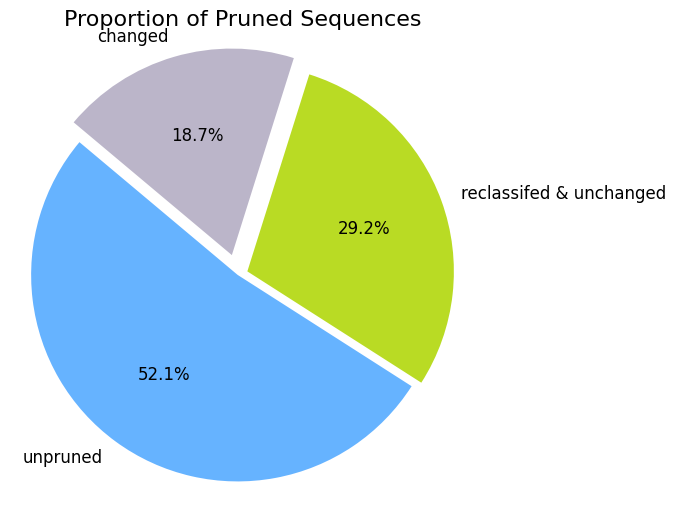

a


In [19]:
total_sequences = 26287#len(loaded_list)
reclassified_sequences = 12604#len(set([i[0] for i in outliers]))
changed_sequences = 4926#len(changed_seq)
unchanged_sequences = total_sequences - reclassified_sequences
reclassified_only = reclassified_sequences - changed_sequences

labels = ['unpruned', 'reclassifed & unchanged', 'changed']
sizes = [unchanged_sequences, reclassified_only, changed_sequences]
colors = ['#66b3ff', "#B9DB24", "#bbb5c9"]
explode = (0, 0.05, 0.1)  # 突出显示

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
plt.title('Proportion of Pruned Sequences', fontsize=16)
plt.axis('equal')
plt.show()
print("a")

## 使用特化模型删低阈值

### 使用特化模型对每一步进行评估

***可以调整顺序，让相同模型的损失计算在一起，减少重复计算***

In [20]:
#计算每个序列的损失

setting_loss_list=[None]*len(loaded_list)
time_loss_list=[None]*len(loaded_list)
for i in range(len(loaded_list)):
    seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
    seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
    time_criterion = nn.MSELoss(reduction= "sum")
    setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
    if final_assignment_list[i] >= len(models):
        setting_loss_list[i] = [0]
        time_loss_list[i] = [0]
        continue
    model = models[final_assignment_list[i]]

    #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
    #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
    deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
    setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

    deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
    setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

    input_len = seq_time.shape[0] - 2#输出输出的长度
    length = torch.tensor([input_len])

    #模型预测
    predict_deltaT, predict_setting,_ = model(deltaT_inputs, setting_inputs, length)
    
    #计算损失
    seq_time_loss_tensor=[time_criterion(predict_deltaT.squeeze(0)[i], deltaT_targets.squeeze(0)[i]) for i in range(predict_deltaT.squeeze(0).shape[0])]
    seq_setting_loss_tensor=[setting_criterion(predict_setting.squeeze(0)[i].unsqueeze(0), setting_targets.squeeze(0)[i].unsqueeze(0)) for i in range(predict_setting.squeeze(0).shape[0])]
    
    seq_setting_loss_list=[_.item() for _ in seq_time_loss_tensor]
    seq_time_loss_list=[_.item() for _ in seq_setting_loss_tensor]
    setting_loss_list[i]=seq_setting_loss_list
    time_loss_list[i]=seq_time_loss_list

#total_loss_list代表每个列表每一步的总损失
total_loss_list = [[setting_loss_list[i][j]+ time_loss_list[i][j] for j in range(len(setting_loss_list[i]))]for i in range(len(setting_loss_list)) ]
    
    

In [21]:
#将损失列表展平
#setting_loss_distribution 和 time_loss_distribution分别为设置和时间的损失值展平
setting_loss_distribution=[item for list_item in setting_loss_list for item in list_item]
time_loss_distribution=[item for list_item in time_loss_list for item in list_item]
#Total_step_length为所有步骤的总数
total_step_length=len(setting_loss_distribution)
#将两种损失相加，得到每个步骤的总损失total_loss_distribution
total_loss_distribution=[setting_loss_distribution[i] + time_loss_distribution[i] for i in range(len(setting_loss_distribution))]

In [22]:
threshold=5
setting_threshold = np.percentile(setting_loss_distribution, threshold)
time_threshold = np.percentile(time_loss_distribution, threshold)
print("Setting Loss",threshold,"th Percentile:", setting_threshold,"\nTime Loss ",threshold,"th Percentile:", time_threshold)
total_threshold = np.percentile(total_loss_distribution, threshold)
print("total Loss",threshold,"th Percentile:", total_threshold)

Setting Loss 5 th Percentile: 0.030551792867481713 
Time Loss  5 th Percentile: 0.0017613982083275915
total Loss 5 th Percentile: 0.11132750161923469


In [23]:
outliers = [(i, j) for i, chain in enumerate(total_loss_list) for j, loss in enumerate(chain) if loss < total_threshold]
print("共从",total_step_length,"个步骤中检测到",len(outliers),"个异常值")

共从 411695 个步骤中检测到 20585 个异常值


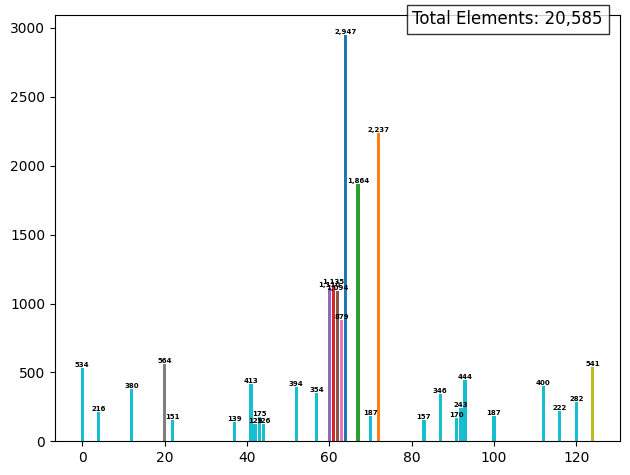

In [24]:
#先绘制被标记的setting分布
Pruned_Setting=[loaded_list[i][0]["combined_setting"].values[j+1] for i, j in outliers] # 仅保留异常值对应的序列
result = Counter(Pruned_Setting).most_common(30)
elements, counts = zip(*result)

# 绘制条形图
colors = plt.cm.tab10(np.arange(len(elements)))
bars = plt.bar(elements, counts, color=colors)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',  # 格式化数字添加千位分隔符
             ha='center', va='bottom',
             fontsize=5, fontweight='bold')
    
    # 添加总数信息
total = len(Pruned_Setting)
plt.figtext(0.95, 0.95, f'Total Elements: {total:,}', 
            ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

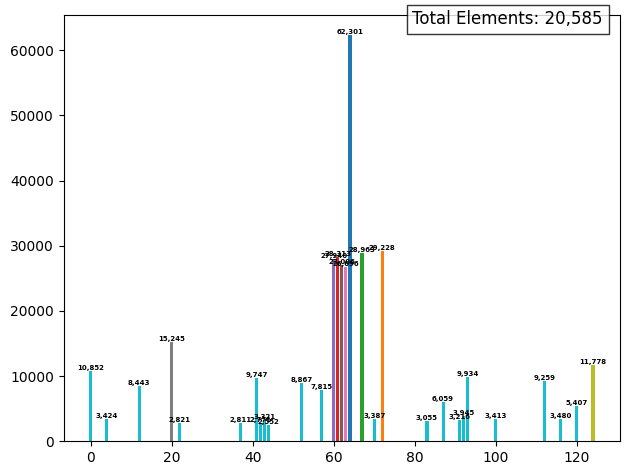

In [25]:
#绘制全体setting分布
All_Setting=[loaded_list[i][0]["combined_setting"].values[j] for i in range(len(loaded_list)) for j in range(len(loaded_list[i][0]["combined_setting"].values))]
result = Counter(All_Setting).most_common(30)
all_elements, counts = zip(*result)

# 绘制条形图
colors = plt.cm.tab10(np.arange(len(elements)))
bars = plt.bar(elements, counts, color=colors)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',  # 格式化数字添加千位分隔符
             ha='center', va='bottom',
             fontsize=5, fontweight='bold')
    
# 添加总数信息
total = len(Pruned_Setting)
plt.figtext(0.95, 0.95, f'Total Elements: {total:,}', 
            ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

### 依据特化模型的标记重新分类

In [26]:
pruned_setting_loss_list=[None]*len(loaded_list)
pruned_time_loss_list=[None]*len(loaded_list)
changed_seq=[]
for i in range(len(loaded_list)):#第i个序列
    seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
    seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
    time_criterion = nn.MSELoss(reduction= "sum")
    setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
    if final_assignment_list[i] >= len(models):
        setting_loss_list[i] = [0]
        time_loss_list[i] = [0]
        continue

    #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
    #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
    deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
    setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

    deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
    setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

    input_len = seq_time.shape[0] - 2#输出输出的长度
    length = torch.tensor([input_len])
    
    #复制原始输入和目标张量，以便在删除异常点后进行修剪,将张量转换为列表（保留二维结构）,存入“pruned_...类型_输入/输出_list”中
    pruned_deltaT_inputs_list, pruned_setting_inputs_list, pruned_deltaT_targets_list, pruned_setting_targets_list= deltaT_inputs.clone().tolist(), setting_inputs.clone().tolist(), deltaT_targets.clone().tolist(), setting_targets.clone().tolist()
    indices_to_remove = [y for _, y in outliers if _ ==i]# 从outlier中提取所有序列标号为i的异常点（即第一个元素为i的数组),忽略x，只取y
    indices_to_remove = sorted(list(set(indices_to_remove)),reverse=True)  # 去重,降序排序(先删后面的，避免改变索引位置),indices_to_remove是储存第i个序列中需要删除的索引列表,注意sorted和.sort的区别
    #***测试用待删print(i,indices_to_remove)

    # 如果没有可删除的，则跳过
    if not indices_to_remove:
        continue
    # 如果所有步骤都是异常点，则跳过
    if len(pruned_deltaT_inputs_list[0]) == len(indices_to_remove):
        print("序列",i,"的所有步骤均为异常点，跳过")
        continue
    for index in indices_to_remove:
        # 检查索引index是否在有效范围内
        if 0 <= index < len(pruned_deltaT_inputs_list[0]):# 删除被标记的步骤 <bug:只删去了t_input的异常点,忘记了其他的>
            del pruned_deltaT_inputs_list[0][index]
            del pruned_setting_inputs_list[0][index]
            del pruned_deltaT_targets_list[0][index]
            del pruned_setting_targets_list[0][index]
        else:
            # 可选：处理索引越界情况（例如打印警告或忽略）
            print(f"警告: 索引 {index} 超出范围，忽略删除")
            # 或者直接忽略

    pruned_deltaT_inputs, pruned_setting_inputs, pruned_deltaT_targets, pruned_setting_targets = torch.tensor(pruned_deltaT_inputs_list).to(device),torch.tensor(pruned_setting_inputs_list).to(device), torch.tensor(pruned_deltaT_targets_list).to(device), torch.tensor(pruned_setting_targets_list).to(device)
    # 现在，pruned_()_() 就是删除异常点后的数据链,<bug:忘记使用to(device)>
    pruned_length = torch.tensor([pruned_deltaT_inputs.shape[1]])#pruned_length为删除后的长度，从数据中取，并转化为张量

    #***检验用待删print(pruned_deltaT_inputs_list.shape,pruned_length, pruned_setting_inputs.shape[1])

    #使用所有模型分别计算损失
    model_loss = [0] * len(models) # 初始化每个模型的损失列表
    for j in range(len(models)):
        model = models[j]

        #模型预测
        pruned_predict_deltaT, pruned_predict_setting,_ = model(pruned_deltaT_inputs, pruned_setting_inputs, pruned_length)

        #计算损失,seq代表按每一步计损失并编入列表
        pruned_seq_time_loss_tensor=[time_criterion(pruned_predict_deltaT.squeeze(0)[i], pruned_deltaT_targets.squeeze(0)[i]) for i in range(pruned_predict_deltaT.squeeze(0).shape[0])]
        pruned_seq_setting_loss_tensor=[setting_criterion(pruned_predict_setting.squeeze(0)[i].unsqueeze(0), pruned_setting_targets.squeeze(0)[i].unsqueeze(0)) for i in range(pruned_predict_setting.squeeze(0).shape[0])]
        pruned_seq_setting_loss_list=[_.item() for _ in pruned_seq_time_loss_tensor]
        pruned_seq_time_loss_list=[_.item() for _ in pruned_seq_setting_loss_tensor]

        model_loss[j] = sum(pruned_seq_setting_loss_list)+ sum(pruned_seq_time_loss_list) # 计算剪后序列i在模型j上的总损失
        #***测试用待删print(model_loss[j])

    min_modelloss = min(model_loss)
    min_modelindex = model_loss.index(min_modelloss)#找出剪后的最佳模型
    if min_modelindex != final_assignment_list[i] and final_assignment_list[i] < len(models):#若与原分配不同，则打印并记录
        print("序列",i,"的最佳模型由",final_assignment_list[i],"变为",min_modelindex)
        changed_seq.append(i)
    #else:
    #    ***测试用待删print("模型损失:",model_loss,"序号不变",final_assignment_list[i])#<bug:在print()立马加入print(model_loss)会输出None>


序列 15 的最佳模型由 2 变为 1
序列 500 的最佳模型由 1 变为 0
序列 549 的最佳模型由 1 变为 2
序列 942 的最佳模型由 2 变为 1
序列 1001 的最佳模型由 2 变为 1
序列 1917 的最佳模型由 2 变为 1
序列 2146 的最佳模型由 2 变为 1
序列 2307 的最佳模型由 1 变为 2
序列 2698 的最佳模型由 2 变为 1
序列 3145 的最佳模型由 1 变为 2
序列 4307 的最佳模型由 2 变为 0
序列 4845 的最佳模型由 1 变为 2
序列 6154 的最佳模型由 2 变为 1
序列 6603 的最佳模型由 1 变为 0
序列 6697 的最佳模型由 2 变为 1
序列 8031 的最佳模型由 1 变为 0
序列 8933 的所有步骤均为异常点，跳过
序列 9338 的最佳模型由 1 变为 2
序列 10798 的最佳模型由 2 变为 1
序列 10838 的最佳模型由 1 变为 2
序列 11812 的最佳模型由 1 变为 2
序列 11986 的最佳模型由 1 变为 2
序列 12554 的最佳模型由 1 变为 2
序列 12563 的最佳模型由 1 变为 2
序列 13212 的最佳模型由 2 变为 1
序列 13278 的最佳模型由 2 变为 1
序列 13945 的最佳模型由 1 变为 2
序列 14384 的最佳模型由 1 变为 2
序列 16044 的最佳模型由 2 变为 0
序列 16729 的最佳模型由 1 变为 2
序列 17872 的最佳模型由 1 变为 2
序列 18631 的最佳模型由 2 变为 1
序列 19284 的最佳模型由 2 变为 1
序列 19428 的最佳模型由 2 变为 1
序列 19766 的最佳模型由 1 变为 2
序列 19832 的最佳模型由 1 变为 2
序列 20725 的最佳模型由 2 变为 1
序列 20733 的最佳模型由 1 变为 0
序列 21022 的最佳模型由 2 变为 0
序列 21036 的最佳模型由 1 变为 2
序列 21132 的最佳模型由 2 变为 1
序列 21682 的所有步骤均为异常点，跳过
序列 21820 的最佳模型由 2 变为 1
序列 21958 的最佳模型由 1 变为 2
序列 22325 的最

In [27]:
print("总序列数",len(loaded_list))
print("标记数（被重新分类的）",len(set([i[0] for i in outliers])))
print("被改变序列数",len(changed_seq))
print()

总序列数 26287
标记数（被重新分类的） 4748
被改变序列数 53



## 使用整体模型删低阈值

### 使用整体模型对每一步进行评估

In [3]:
#计算每个序列的损失
setting_loss_list=[None]*len(loaded_list)
time_loss_list=[None]*len(loaded_list)
for i in range(len(loaded_list)):
    seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
    seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
    time_criterion = nn.MSELoss(reduction= "sum")
    setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
    if final_assignment_list[i] >= len(models):
        setting_loss_list[i] = [0]
        time_loss_list[i] = [0]
        continue
    model = Model

    #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
    #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
    deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
    setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

    deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
    setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

    input_len = seq_time.shape[0] - 2#输出输出的长度
    length = torch.tensor([input_len])

    #模型预测
    predict_deltaT, predict_setting,_ = model(deltaT_inputs, setting_inputs, length)
    
    #计算损失
    seq_time_loss_tensor=[time_criterion(predict_deltaT.squeeze(0)[i], deltaT_targets.squeeze(0)[i]) for i in range(predict_deltaT.squeeze(0).shape[0])]
    seq_setting_loss_tensor=[setting_criterion(predict_setting.squeeze(0)[i].unsqueeze(0), setting_targets.squeeze(0)[i].unsqueeze(0)) for i in range(predict_setting.squeeze(0).shape[0])]
    
    seq_setting_loss_list=[_.item() for _ in seq_time_loss_tensor]
    seq_time_loss_list=[_.item() for _ in seq_setting_loss_tensor]
    setting_loss_list[i]=seq_setting_loss_list
    time_loss_list[i]=seq_time_loss_list

#total_loss_list代表每个列表每一步的总损失
total_loss_list = [[setting_loss_list[i][j]+ time_loss_list[i][j] for j in range(len(setting_loss_list[i]))]for i in range(len(setting_loss_list)) ]
    
    

In [4]:
#将损失列表展平
#setting_loss_distribution 和 time_loss_distribution分别为设置和时间的损失值展平
setting_loss_distribution=[item for list_item in setting_loss_list for item in list_item]
time_loss_distribution=[item for list_item in time_loss_list for item in list_item]
#Total_step_length为所有步骤的总数
total_step_length=len(setting_loss_distribution)
#将两种损失相加，得到每个步骤的总损失total_loss_distribution
total_loss_distribution=[setting_loss_distribution[i] + time_loss_distribution[i] for i in range(len(setting_loss_distribution))]

In [30]:
threshold=50
setting_threshold = np.percentile(setting_loss_distribution, threshold)
time_threshold = np.percentile(time_loss_distribution, threshold)
print("Setting Loss",threshold,"th Percentile:", setting_threshold,"\nTime Loss ",threshold,"th Percentile:", time_threshold)
total_threshold = np.percentile(total_loss_distribution, threshold)
print("total Loss",threshold,"th Percentile:", total_threshold)

Setting Loss 50 th Percentile: 8.508066177368164 
Time Loss  50 th Percentile: 3.879849910736084
total Loss 50 th Percentile: 12.557314395904541


In [31]:
outliers = [(i, j) for i, chain in enumerate(total_loss_list) for j, loss in enumerate(chain) if loss < total_threshold]
print("共从",total_step_length,"个步骤中检测到",len(outliers),"个异常值")

共从 411695 个步骤中检测到 205847 个异常值


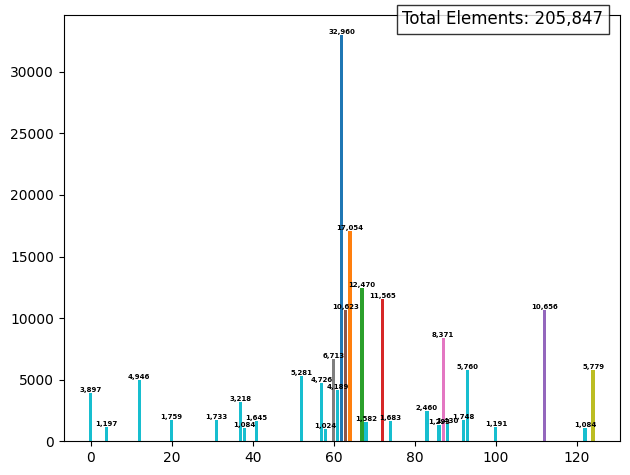

In [32]:
#先绘制被标记setting分布
Pruned_Setting=[loaded_list[i][0]["combined_setting"].values[j+1] for i, j in outliers] # 仅保留异常值对应的序列
result = Counter(Pruned_Setting).most_common(30)
elements, counts = zip(*result)

# 绘制条形图
colors = plt.cm.tab10(np.arange(len(elements)))
bars = plt.bar(elements, counts, color=colors)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',  # 格式化数字添加千位分隔符
             ha='center', va='bottom',
             fontsize=5, fontweight='bold')
    
    # 添加总数信息
total = len(Pruned_Setting)
plt.figtext(0.95, 0.95, f'Total Elements: {total:,}', 
            ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

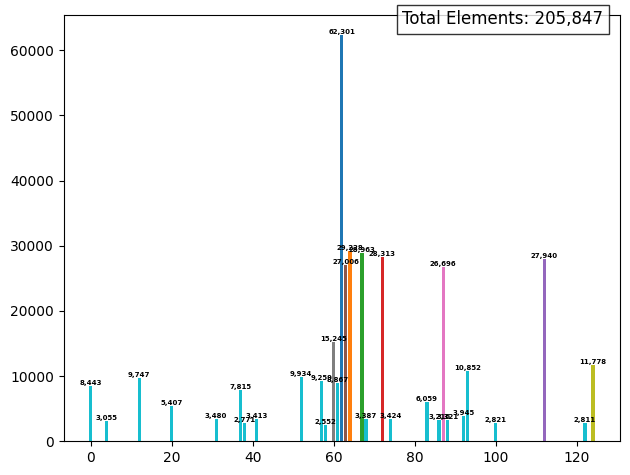

In [33]:
#绘制全体setting分布
All_Setting=[loaded_list[i][0]["combined_setting"].values[j] for i in range(len(loaded_list)) for j in range(len(loaded_list[i][0]["combined_setting"].values))]
result = Counter(All_Setting).most_common(30)
all_elements, counts = zip(*result)

# 绘制条形图
colors = plt.cm.tab10(np.arange(len(elements)))
bars = plt.bar(elements, counts, color=colors)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',  # 格式化数字添加千位分隔符
             ha='center', va='bottom',
             fontsize=5, fontweight='bold')
    
# 添加总数信息
total = len(Pruned_Setting)
plt.figtext(0.95, 0.95, f'Total Elements: {total:,}', 
            ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

### 依据整体模型的标记重新分类

In [34]:
pruned_setting_loss_list=[None]*len(loaded_list)
pruned_time_loss_list=[None]*len(loaded_list)
changed_seq=[]
for i in range(len(loaded_list)):#第i个序列
    seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
    seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
    time_criterion = nn.MSELoss(reduction= "sum")
    setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
    if final_assignment_list[i] >= len(models):
        setting_loss_list[i] = [0]
        time_loss_list[i] = [0]
        continue

    #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
    #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
    deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
    setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

    deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
    setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

    input_len = seq_time.shape[0] - 2#输出输出的长度
    length = torch.tensor([input_len])
    
    #复制原始输入和目标张量，以便在删除异常点后进行修剪,将张量转换为列表（保留二维结构）,存入“pruned_...类型_输入/输出_list”中
    pruned_deltaT_inputs_list, pruned_setting_inputs_list, pruned_deltaT_targets_list, pruned_setting_targets_list= deltaT_inputs.clone().tolist(), setting_inputs.clone().tolist(), deltaT_targets.clone().tolist(), setting_targets.clone().tolist()
    indices_to_remove = [y for _, y in outliers if _ ==i]# 从outlier中提取所有序列标号为i的异常点（即第一个元素为i的数组),忽略x，只取y
    indices_to_remove = sorted(list(set(indices_to_remove)),reverse=True)  # 去重,降序排序(先删后面的，避免改变索引位置),indices_to_remove是储存第i个序列中需要删除的索引列表,注意sorted和.sort的区别
    #***测试用待删print(i,indices_to_remove)

    # 如果没有可删除的，则跳过
    if not indices_to_remove:
        continue
    # 如果所有步骤都是异常点，则跳过
    # ***是否要记录所有步骤都异常的序列的总数**？
    if len(pruned_deltaT_inputs_list[0]) == len(indices_to_remove):
        print("序列",i,"的所有步骤均为异常点，跳过")
        continue
    for index in indices_to_remove:
        # 检查索引index是否在有效范围内
        if 0 <= index < len(pruned_deltaT_inputs_list[0]):# 删除被标记的步骤 <bug:只删去了t_input的异常点,忘记了其他的>
            del pruned_deltaT_inputs_list[0][index]
            del pruned_setting_inputs_list[0][index]
            del pruned_deltaT_targets_list[0][index]
            del pruned_setting_targets_list[0][index]
        else:
            # 可选：处理索引越界情况（例如打印警告或忽略）
            print(f"警告: 索引 {index} 超出范围，忽略删除")
            # 或者直接忽略

    pruned_deltaT_inputs, pruned_setting_inputs, pruned_deltaT_targets, pruned_setting_targets = torch.tensor(pruned_deltaT_inputs_list).to(device),torch.tensor(pruned_setting_inputs_list).to(device), torch.tensor(pruned_deltaT_targets_list).to(device), torch.tensor(pruned_setting_targets_list).to(device)
    # 现在，pruned_()_() 就是删除异常点后的数据链,<bug:忘记使用to(device)>
    pruned_length = torch.tensor([pruned_deltaT_inputs.shape[1]])#pruned_length为删除后的长度，从数据中取，并转化为张量

    #***检验用待删print(pruned_deltaT_inputs_list.shape,pruned_length, pruned_setting_inputs.shape[1])

    #使用所有模型分别计算损失
    model_loss = [0] * len(models) # 初始化每个模型的损失列表
    for j in range(len(models)):
        model = models[j]

        #模型预测
        pruned_predict_deltaT, pruned_predict_setting,_ = model(pruned_deltaT_inputs, pruned_setting_inputs, pruned_length)

        #计算损失,seq代表按每一步计损失并编入列表
        pruned_seq_time_loss_tensor=[time_criterion(pruned_predict_deltaT.squeeze(0)[i], pruned_deltaT_targets.squeeze(0)[i]) for i in range(pruned_predict_deltaT.squeeze(0).shape[0])]
        pruned_seq_setting_loss_tensor=[setting_criterion(pruned_predict_setting.squeeze(0)[i].unsqueeze(0), pruned_setting_targets.squeeze(0)[i].unsqueeze(0)) for i in range(pruned_predict_setting.squeeze(0).shape[0])]
        pruned_seq_setting_loss_list=[_.item() for _ in pruned_seq_time_loss_tensor]
        pruned_seq_time_loss_list=[_.item() for _ in pruned_seq_setting_loss_tensor]

        model_loss[j] = sum(pruned_seq_setting_loss_list)+ sum(pruned_seq_time_loss_list) # 计算剪后序列i在模型j上的总损失
        #***测试用待删print(model_loss[j])

    min_modelloss = min(model_loss)
    min_modelindex = model_loss.index(min_modelloss)#找出剪后的最佳模型
    if min_modelindex != final_assignment_list[i] and final_assignment_list[i] < len(models):#若与原分配不同，则打印并记录
        print("序列",i,"的最佳模型由",final_assignment_list[i],"变为",min_modelindex)
        changed_seq.append(i)
    #else:
    #    ***测试用待删print("模型损失:",model_loss,"序号不变",final_assignment_list[i])#<bug:在print()立马加入print(model_loss)会输出None>

print("总序列数",len(loaded_list))
print("标记数（被重新分类的）",len(set([i[0] for i in outliers])))
print("被改变序列数",len(changed_seq))
print()

序列 0 的最佳模型由 2 变为 1
序列 2 的最佳模型由 1 变为 0
序列 3 的最佳模型由 1 变为 2
序列 4 的最佳模型由 2 变为 1
序列 6 的所有步骤均为异常点，跳过
序列 9 的最佳模型由 2 变为 1
序列 10 的最佳模型由 1 变为 0
序列 14 的所有步骤均为异常点，跳过
序列 22 的最佳模型由 2 变为 1
序列 27 的所有步骤均为异常点，跳过
序列 39 的所有步骤均为异常点，跳过
序列 40 的最佳模型由 2 变为 1
序列 43 的所有步骤均为异常点，跳过
序列 44 的最佳模型由 2 变为 1
序列 58 的最佳模型由 1 变为 2
序列 66 的所有步骤均为异常点，跳过
序列 71 的所有步骤均为异常点，跳过
序列 73 的所有步骤均为异常点，跳过
序列 79 的最佳模型由 1 变为 2
序列 80 的最佳模型由 2 变为 0
序列 83 的最佳模型由 1 变为 2
序列 92 的最佳模型由 1 变为 0
序列 97 的最佳模型由 1 变为 2
序列 103 的所有步骤均为异常点，跳过
序列 111 的所有步骤均为异常点，跳过
序列 114 的最佳模型由 2 变为 0
序列 123 的所有步骤均为异常点，跳过
序列 127 的最佳模型由 2 变为 1
序列 131 的最佳模型由 2 变为 1
序列 134 的最佳模型由 1 变为 2
序列 140 的最佳模型由 2 变为 0
序列 144 的最佳模型由 0 变为 1
序列 146 的最佳模型由 2 变为 1
序列 147 的最佳模型由 2 变为 1
序列 150 的最佳模型由 2 变为 1
序列 175 的最佳模型由 2 变为 1
序列 183 的最佳模型由 1 变为 0
序列 186 的最佳模型由 1 变为 2
序列 194 的所有步骤均为异常点，跳过
序列 197 的最佳模型由 1 变为 2
序列 210 的最佳模型由 2 变为 1
序列 215 的最佳模型由 1 变为 2
序列 240 的最佳模型由 1 变为 2
序列 245 的最佳模型由 1 变为 2
序列 262 的最佳模型由 2 变为 1
序列 265 的所有步骤均为异常点，跳过
序列 275 的最佳模型由 2 变为 1
序列 279 的最佳模型由 0 变为 1
序列 287 的最佳模型由 1 变为 2


In [35]:
print("总序列数",len(loaded_list))
print("标记数（被重新分类的）",len(set([i[0] for i in outliers])))
print("被改变序列数",len(changed_seq))
print()

总序列数 26287
标记数（被重新分类的） 22731
被改变序列数 3739



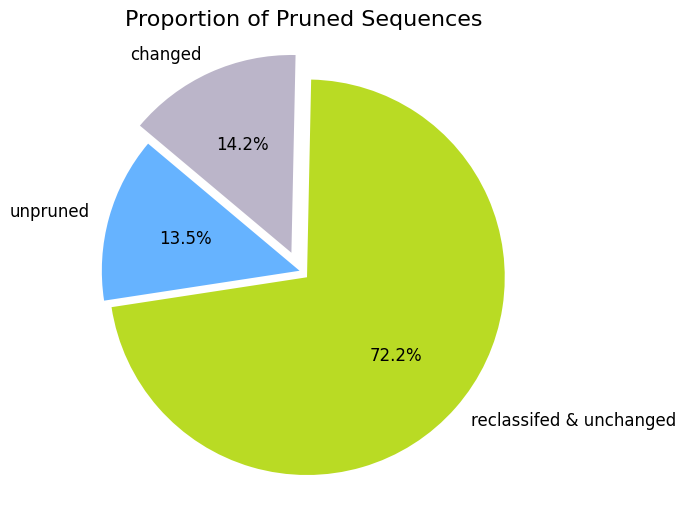

a


In [36]:
total_sequences = len(loaded_list)
reclassified_sequences = len(set([i[0] for i in outliers]))
changed_sequences = len(changed_seq)
unchanged_sequences = total_sequences - reclassified_sequences
reclassified_only = reclassified_sequences - changed_sequences

labels = ['unpruned', 'reclassifed & unchanged', 'changed']
sizes = [unchanged_sequences, reclassified_only, changed_sequences]
colors = ['#66b3ff', "#B9DB24", "#bbb5c9"]
explode = (0, 0.05, 0.1)  # 突出显示

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
plt.title('Proportion of Pruned Sequences', fontsize=16)
plt.axis('equal')
plt.show()
print("a")

# 使用最小损失

### 使用特化模型分别对每一步进行评估，并取最小值

In [6]:
total_loss_list

[[52.604900598526,
  11.135429382324219,
  58.0242817401886,
  11.335063934326172,
  50.76579427719116,
  33.71699905395508,
  9.979758977890015,
  258.2576732635498],
 [45.083715200424194,
  114.51193571090698,
  51.04230451583862,
  41.565996170043945],
 [3.3648345470428467,
  9.319291889667511,
  58.40212965011597,
  26.661149978637695,
  8.307863861322403],
 [62.40633416175842, 9.353339433670044, 10.672950148582458],
 [10.936326503753662,
  9.937702178955078,
  13.354425191879272,
  17.412366151809692,
  18.299296855926514,
  28.846794366836548,
  2.6557148694992065,
  11.270098209381104,
  30.19899010658264,
  15.27887225151062,
  4.342249512672424,
  50.60405659675598,
  52.30847406387329,
  20.567948818206787,
  13.975927829742432,
  3.501169204711914],
 [6.086622595787048, 2089.110462665558, 7.113423615694046, 33.53807258605957],
 [1.9081910848617554],
 [31.824223518371582],
 [128.61968088150024,
  17.232456922531128,
  6.511966824531555,
  30.92704439163208,
  22.6644840240478

In [10]:
total_model_loss_list = [None]*len(models)
for k in range(len(models)):
    model = models[k]
    #计算每个序列的损失
    setting_loss_list=[None]*len(loaded_list)
    time_loss_list=[None]*len(loaded_list)
    for i in range(len(loaded_list)):
        seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
        seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
        time_criterion = nn.MSELoss(reduction= "sum")
        setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
        if final_assignment_list[i] >= len(models):
            setting_loss_list[i] = [0]
            time_loss_list[i] = [0]
            continue

        #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
        #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
        deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
        setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)
        deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
        setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)
        input_len = seq_time.shape[0] - 2#输出输出的长度
        length = torch.tensor([input_len])

        #模型预测
        predict_deltaT, predict_setting,_ = model(deltaT_inputs, setting_inputs, length)
        
        #计算损失
        seq_time_loss_tensor=[time_criterion(predict_deltaT.squeeze(0)[i], deltaT_targets.squeeze(0)[i]) for i in range(predict_deltaT.squeeze(0).shape[0])]
        seq_setting_loss_tensor=[setting_criterion(predict_setting.squeeze(0)[i].unsqueeze(0), setting_targets.squeeze(0)[i].unsqueeze(0)) for i in range(predict_setting.squeeze(0).shape[0])]
        
        seq_setting_loss_list=[_.item() for _ in seq_time_loss_tensor]
        seq_time_loss_list=[_.item() for _ in seq_setting_loss_tensor]
        setting_loss_list[i]=seq_setting_loss_list
        time_loss_list[i]=seq_time_loss_list

    #total_loss_list代表每个列表每一步的总损失
    total_model_loss_list[k] = [[setting_loss_list[i][j]+ time_loss_list[i][j] for j in range(len(setting_loss_list[i]))]for i in range(len(setting_loss_list)) ]

In [11]:
def get_min_list(total_loss_list):
    K = len(total_loss_list)  # 一级子列表的数量
    if K == 0:
        return []  # 如果列表为空，直接返回空列表
    I = len(total_loss_list[0])  # 二级子列表的数量
    min_list = []  # 初始化结果列表
    for i in range(I):
        # 获取第i个二级子列表的元素数量J_i（所有一级子列表的该二级子列表长度相同）
        J_i = len(total_loss_list[0][i])
        current_min_sublist = []  # 初始化当前二级子列表的最小值列表
        for j in range(J_i):
            # 收集所有一级子列表在第i个二级子列表第j个元素的值
            values = [total_loss_list[k][i][j] for k in range(K)]
            min_value = min(values)  # 取最小值
            current_min_sublist.append(min_value)
        min_list.append(current_min_sublist)
    return min_list

In [12]:
total_loss_list = get_min_list(total_model_loss_list)


In [ ]:
total_loss_distribution=[item for list_item in total_loss_list for item in list_item]

In [ ]:
threshold=50
setting_threshold = np.percentile(setting_loss_distribution, threshold)
time_threshold = np.percentile(time_loss_distribution, threshold)
print("Setting Loss",threshold,"th Percentile:", setting_threshold,"\nTime Loss ",threshold,"th Percentile:", time_threshold)
total_threshold = np.percentile(total_loss_distribution, threshold)
print("total Loss",threshold,"th Percentile:", total_threshold)

Setting Loss 50 th Percentile: 8.508066177368164 
Time Loss  50 th Percentile: 3.879849910736084
total Loss 50 th Percentile: 12.557314395904541


In [ ]:
outliers = [(i, j) for i, chain in enumerate(total_loss_list) for j, loss in enumerate(chain) if loss < total_threshold]
print("共从",total_step_length,"个步骤中检测到",len(outliers),"个异常值")

共从 411695 个步骤中检测到 205847 个异常值


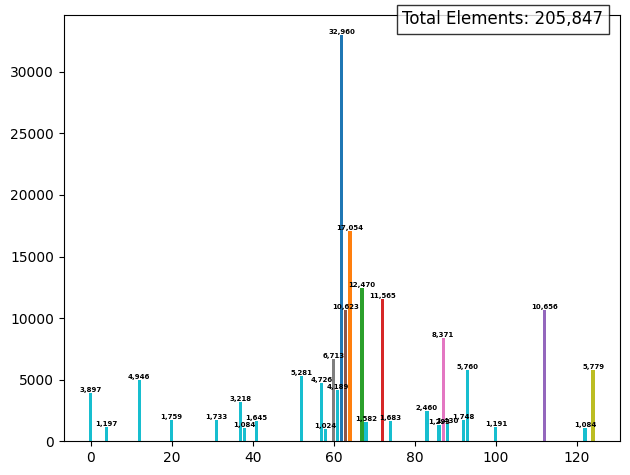

In [ ]:
#先绘制被标记setting分布
Pruned_Setting=[loaded_list[i][0]["combined_setting"].values[j+1] for i, j in outliers] # 仅保留异常值对应的序列
result = Counter(Pruned_Setting).most_common(30)
elements, counts = zip(*result)

# 绘制条形图
colors = plt.cm.tab10(np.arange(len(elements)))
bars = plt.bar(elements, counts, color=colors)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',  # 格式化数字添加千位分隔符
             ha='center', va='bottom',
             fontsize=5, fontweight='bold')
    
    # 添加总数信息
total = len(Pruned_Setting)
plt.figtext(0.95, 0.95, f'Total Elements: {total:,}', 
            ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

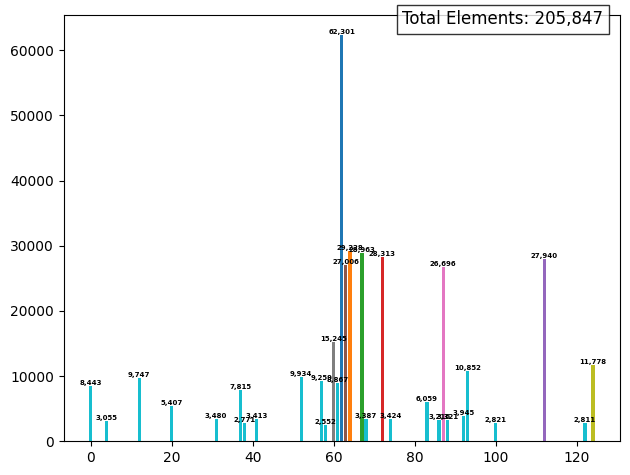

In [ ]:
#绘制全体setting分布
All_Setting=[loaded_list[i][0]["combined_setting"].values[j] for i in range(len(loaded_list)) for j in range(len(loaded_list[i][0]["combined_setting"].values))]
result = Counter(All_Setting).most_common(30)
all_elements, counts = zip(*result)

# 绘制条形图
colors = plt.cm.tab10(np.arange(len(elements)))
bars = plt.bar(elements, counts, color=colors)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',  # 格式化数字添加千位分隔符
             ha='center', va='bottom',
             fontsize=5, fontweight='bold')
    
# 添加总数信息
total = len(Pruned_Setting)
plt.figtext(0.95, 0.95, f'Total Elements: {total:,}', 
            ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

### 依据最契合的标记重新分类

In [ ]:
pruned_setting_loss_list=[None]*len(loaded_list)
pruned_time_loss_list=[None]*len(loaded_list)
changed_seq=[]
for i in range(len(loaded_list)):#第i个序列
    seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
    seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
    time_criterion = nn.MSELoss(reduction= "sum")
    setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
    if final_assignment_list[i] >= len(models):
        setting_loss_list[i] = [0]
        time_loss_list[i] = [0]
        continue

    #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
    #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
    deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
    setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

    deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
    setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

    input_len = seq_time.shape[0] - 2#输出输出的长度
    length = torch.tensor([input_len])
    
    #复制原始输入和目标张量，以便在删除异常点后进行修剪,将张量转换为列表（保留二维结构）,存入“pruned_...类型_输入/输出_list”中
    pruned_deltaT_inputs_list, pruned_setting_inputs_list, pruned_deltaT_targets_list, pruned_setting_targets_list= deltaT_inputs.clone().tolist(), setting_inputs.clone().tolist(), deltaT_targets.clone().tolist(), setting_targets.clone().tolist()
    indices_to_remove = [y for _, y in outliers if _ ==i]# 从outlier中提取所有序列标号为i的异常点（即第一个元素为i的数组),忽略x，只取y
    indices_to_remove = sorted(list(set(indices_to_remove)),reverse=True)  # 去重,降序排序(先删后面的，避免改变索引位置),indices_to_remove是储存第i个序列中需要删除的索引列表,注意sorted和.sort的区别
    #***测试用待删print(i,indices_to_remove)

    # 如果没有可删除的，则跳过
    if not indices_to_remove:
        continue
    # 如果所有步骤都是异常点，则跳过
    # ***是否要记录所有步骤都异常的序列的总数**？
    if len(pruned_deltaT_inputs_list[0]) == len(indices_to_remove):
        print("序列",i,"的所有步骤均为异常点，跳过")
        continue
    for index in indices_to_remove:
        # 检查索引index是否在有效范围内
        if 0 <= index < len(pruned_deltaT_inputs_list[0]):# 删除被标记的步骤 <bug:只删去了t_input的异常点,忘记了其他的>
            del pruned_deltaT_inputs_list[0][index]
            del pruned_setting_inputs_list[0][index]
            del pruned_deltaT_targets_list[0][index]
            del pruned_setting_targets_list[0][index]
        else:
            # 可选：处理索引越界情况（例如打印警告或忽略）
            print(f"警告: 索引 {index} 超出范围，忽略删除")
            # 或者直接忽略

    pruned_deltaT_inputs, pruned_setting_inputs, pruned_deltaT_targets, pruned_setting_targets = torch.tensor(pruned_deltaT_inputs_list).to(device),torch.tensor(pruned_setting_inputs_list).to(device), torch.tensor(pruned_deltaT_targets_list).to(device), torch.tensor(pruned_setting_targets_list).to(device)
    # 现在，pruned_()_() 就是删除异常点后的数据链,<bug:忘记使用to(device)>
    pruned_length = torch.tensor([pruned_deltaT_inputs.shape[1]])#pruned_length为删除后的长度，从数据中取，并转化为张量

    #***检验用待删print(pruned_deltaT_inputs_list.shape,pruned_length, pruned_setting_inputs.shape[1])

    #使用所有模型分别计算损失
    model_loss = [0] * len(models) # 初始化每个模型的损失列表
    for j in range(len(models)):
        model = models[j]

        #模型预测
        pruned_predict_deltaT, pruned_predict_setting,_ = model(pruned_deltaT_inputs, pruned_setting_inputs, pruned_length)

        #计算损失,seq代表按每一步计损失并编入列表
        pruned_seq_time_loss_tensor=[time_criterion(pruned_predict_deltaT.squeeze(0)[i], pruned_deltaT_targets.squeeze(0)[i]) for i in range(pruned_predict_deltaT.squeeze(0).shape[0])]
        pruned_seq_setting_loss_tensor=[setting_criterion(pruned_predict_setting.squeeze(0)[i].unsqueeze(0), pruned_setting_targets.squeeze(0)[i].unsqueeze(0)) for i in range(pruned_predict_setting.squeeze(0).shape[0])]
        pruned_seq_setting_loss_list=[_.item() for _ in pruned_seq_time_loss_tensor]
        pruned_seq_time_loss_list=[_.item() for _ in pruned_seq_setting_loss_tensor]

        model_loss[j] = sum(pruned_seq_setting_loss_list)+ sum(pruned_seq_time_loss_list) # 计算剪后序列i在模型j上的总损失
        #***测试用待删print(model_loss[j])

    min_modelloss = min(model_loss)
    min_modelindex = model_loss.index(min_modelloss)#找出剪后的最佳模型
    if min_modelindex != final_assignment_list[i] and final_assignment_list[i] < len(models):#若与原分配不同，则打印并记录
        print("序列",i,"的最佳模型由",final_assignment_list[i],"变为",min_modelindex)
        changed_seq.append(i)
    #else:
    #    ***测试用待删print("模型损失:",model_loss,"序号不变",final_assignment_list[i])#<bug:在print()立马加入print(model_loss)会输出None>

print("总序列数",len(loaded_list))
print("标记数（被重新分类的）",len(set([i[0] for i in outliers])))
print("被改变序列数",len(changed_seq))
print()

序列 0 的最佳模型由 2 变为 1
序列 2 的最佳模型由 1 变为 0
序列 3 的最佳模型由 1 变为 2
序列 4 的最佳模型由 2 变为 1
序列 6 的所有步骤均为异常点，跳过
序列 9 的最佳模型由 2 变为 1
序列 10 的最佳模型由 1 变为 0
序列 14 的所有步骤均为异常点，跳过
序列 22 的最佳模型由 2 变为 1
序列 27 的所有步骤均为异常点，跳过
序列 39 的所有步骤均为异常点，跳过
序列 40 的最佳模型由 2 变为 1
序列 43 的所有步骤均为异常点，跳过
序列 44 的最佳模型由 2 变为 1
序列 58 的最佳模型由 1 变为 2
序列 66 的所有步骤均为异常点，跳过
序列 71 的所有步骤均为异常点，跳过
序列 73 的所有步骤均为异常点，跳过
序列 79 的最佳模型由 1 变为 2
序列 80 的最佳模型由 2 变为 0
序列 83 的最佳模型由 1 变为 2
序列 92 的最佳模型由 1 变为 0
序列 97 的最佳模型由 1 变为 2
序列 103 的所有步骤均为异常点，跳过
序列 111 的所有步骤均为异常点，跳过
序列 114 的最佳模型由 2 变为 0
序列 123 的所有步骤均为异常点，跳过
序列 127 的最佳模型由 2 变为 1
序列 131 的最佳模型由 2 变为 1
序列 134 的最佳模型由 1 变为 2
序列 140 的最佳模型由 2 变为 0
序列 144 的最佳模型由 0 变为 1
序列 146 的最佳模型由 2 变为 1
序列 147 的最佳模型由 2 变为 1
序列 150 的最佳模型由 2 变为 1
序列 175 的最佳模型由 2 变为 1
序列 183 的最佳模型由 1 变为 0
序列 186 的最佳模型由 1 变为 2
序列 194 的所有步骤均为异常点，跳过
序列 197 的最佳模型由 1 变为 2
序列 210 的最佳模型由 2 变为 1
序列 215 的最佳模型由 1 变为 2
序列 240 的最佳模型由 1 变为 2
序列 245 的最佳模型由 1 变为 2
序列 262 的最佳模型由 2 变为 1
序列 265 的所有步骤均为异常点，跳过
序列 275 的最佳模型由 2 变为 1
序列 279 的最佳模型由 0 变为 1
序列 287 的最佳模型由 1 变为 2


In [ ]:
print("总序列数",len(loaded_list))
print("标记数（被重新分类的）",len(set([i[0] for i in outliers])))
print("被改变序列数",len(changed_seq))
print()

总序列数 26287
标记数（被重新分类的） 22731
被改变序列数 3739



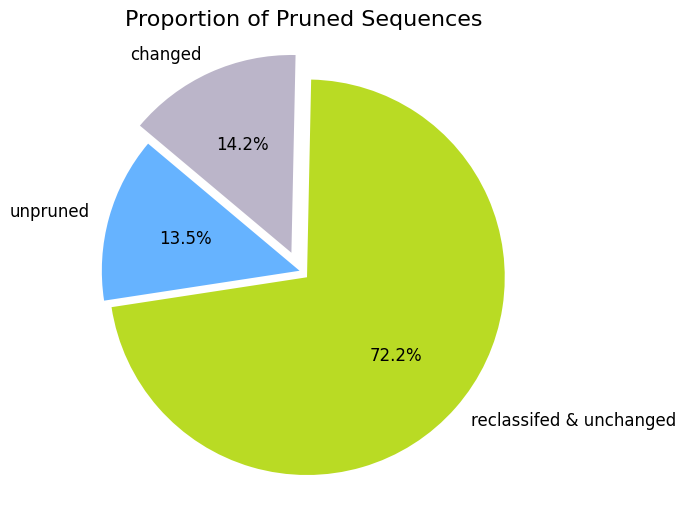

a


In [ ]:
total_sequences = len(loaded_list)
reclassified_sequences = len(set([i[0] for i in outliers]))
changed_sequences = len(changed_seq)
unchanged_sequences = total_sequences - reclassified_sequences
reclassified_only = reclassified_sequences - changed_sequences

labels = ['unpruned', 'reclassifed & unchanged', 'changed']
sizes = [unchanged_sequences, reclassified_only, changed_sequences]
colors = ['#66b3ff', "#B9DB24", "#bbb5c9"]
explode = (0, 0.05, 0.1)  # 突出显示

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
plt.title('Proportion of Pruned Sequences', fontsize=16)
plt.axis('equal')
plt.show()
print("a")

## 描述

In [37]:
print("设置损失值与时间损失值的总值比例：",sum(setting_loss_distribution)/sum(time_loss_distribution))
print("设置损失值与时间损失值的标准差比例：",np.std(setting_loss_distribution)/np.std(time_loss_distribution))


#是否需要将训练时的比例改为20:1

设置损失值与时间损失值的总值比例： 11.221233121659548
设置损失值与时间损失值的标准差比例： 283.0749489093401


In [38]:


i=4
#print("df\n",loaded_list[i][0]);print("cluster of model",final_assignment_list[i])
seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
time_criterion = nn.MSELoss(reduction= "sum")
setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
model = models[final_assignment_list[i]]

#deltaT_inputs是时间差的输入，setting_inputs是设置的输入
#使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

input_len = seq_time.shape[0] - 2#输出输出的长度
length = torch.tensor([input_len])

#模型预测
predict_deltaT, predict_setting,_ = model(deltaT_inputs, setting_inputs, length)

#计算损失
seq_time_loss_tensor=[time_criterion(predict_deltaT.squeeze(0)[i], deltaT_targets.squeeze(0)[i]) for i in range(predict_deltaT.squeeze(0).shape[0])]
seq_setting_loss_tensor=[setting_criterion(predict_setting.squeeze(0)[i].unsqueeze(0), setting_targets.squeeze(0)[i].unsqueeze(0)) for i in range(predict_setting.squeeze(0).shape[0])]

seq_setting_loss_list=[_.item() for _ in seq_time_loss_tensor]
seq_time_loss_list=[_.item() for _ in seq_setting_loss_tensor]

### 绘图

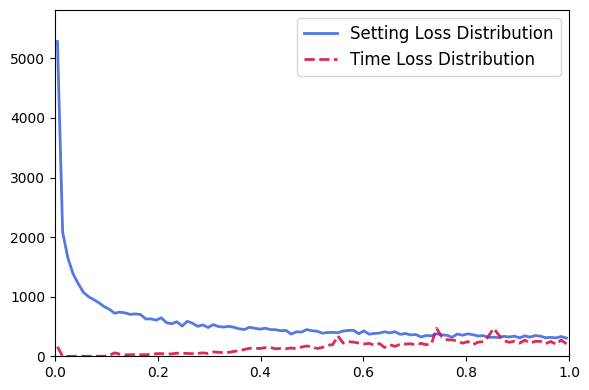

In [39]:
# 绘制分布图
plt.figure(figsize=(6, 4), dpi=100)
x_range = (0, 1)
bins = np.linspace(*x_range, 100)  # 使用500个柱子获得平滑曲线
hist1, bin_edges1 = np.histogram(setting_loss_distribution, bins=bins)
hist2, bin_edges2 = np.histogram(time_loss_distribution, bins=bins)
bin_centers = (bin_edges1[:-1] + bin_edges1[1:]) / 2

plt.plot(bin_centers, hist1, 
         linewidth=2, 
         color='royalblue', 
         alpha=0.9,
         label='Setting Loss Distribution')
plt.plot(bin_centers, hist2, 
         linewidth=2, 
         color='crimson', 
         alpha=0.9,
         linestyle='--',
         label='Time Loss Distribution')

plt.xlim(x_range)
plt.ylim(0, max(np.max(hist1), np.max(hist2)) * 1.1)  # 自动设置y轴上限
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()

plt.show()

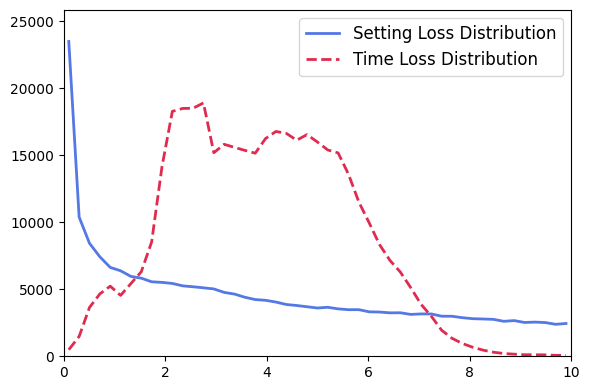

In [40]:
# 绘制分布图
plt.figure(figsize=(6, 4), dpi=100)
x_range = (0, 10)
bins = np.linspace(*x_range, 50)  # 使用50个柱子获得平滑曲线
hist1, bin_edges1 = np.histogram(setting_loss_distribution, bins=bins)
hist2, bin_edges2 = np.histogram(time_loss_distribution, bins=bins)
bin_centers = (bin_edges1[:-1] + bin_edges1[1:]) / 2

plt.plot(bin_centers, hist1, 
         linewidth=2, 
         color='royalblue', 
         alpha=0.9,
         label='Setting Loss Distribution')
plt.plot(bin_centers, hist2, 
         linewidth=2, 
         color='crimson', 
         alpha=0.9,
         linestyle='--',
         label='Time Loss Distribution')

plt.xlim(x_range)
plt.ylim(0, max(np.max(hist1), np.max(hist2)) * 1.1)  # 自动设置y轴上限
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()

plt.show()

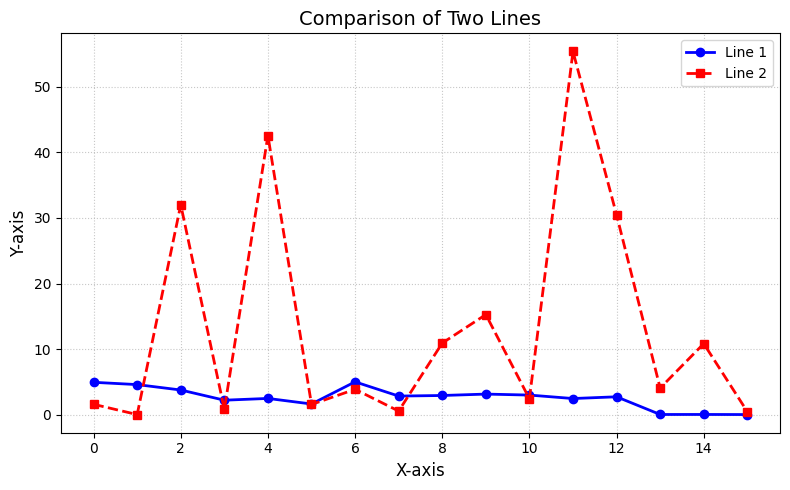

In [41]:
# 创建画布和坐标轴
plt.figure(figsize=(8, 5))  # 设置画布大小
x_values = range(len(seq_setting_loss_list))  # 公共的横坐标（若未指定则用索引）
# 绘制两条折线
plt.plot(x_values,seq_time_loss_list, 
         marker='o',         # 数据点标记为圆形
         label='Line 1',     # 图例标签
         color='blue',       # 线条颜色
         linewidth=2)        # 线宽

plt.plot(x_values, seq_setting_loss_list, 
         marker='s',         # 数据点标记为方形
         label='Line 2', 
         color='red', 
         linestyle='--',     # 虚线样式
         linewidth=2)

# 添加标题和标签
plt.title('Comparison of Two Lines', fontsize=14)
plt.xlabel('X-axis', fontsize=12)
plt.ylabel('Y-axis', fontsize=12)

# 添加图例和网格
plt.legend(fontsize=10)       # 显示图例
plt.grid(True, linestyle=':', alpha=0.7)  # 虚线网格

# 自动调整布局并显示
plt.tight_layout()
plt.show()

In [42]:
def StepwiseLoss(model, data, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for sequence in data:
            sequence = sequence.to(device)
            output, _ = model(sequence)
            loss = model.calculate_loss(output, sequence)
            total_loss += loss.item()
    return total_loss / len(data)